In [1]:
import sys
sys.path.append("../../../")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse, Patch

from scipy.stats import chi2, norm


from LRM.plotting import set_plot_style
from LRM.CMP import CMP, SmoothedEmpiricalDensity

set_plot_style()

In [2]:

def _ellipse_params_from_cov(mu, Sigma, q):
    """
    For 2x2 Sigma and center mu, return (width, height, angle_degrees)
    for the ellipse corresponding to (x-mu)^T Sigma^{-1} (x-mu) = q.
    q is typically a chi-square quantile with df=2 for probability mass p.
    """
    mu = np.asarray(mu, float).reshape(2)
    Sigma = np.asarray(Sigma, float).reshape(2, 2)
    # eigen-decomposition (ascending), sort to ensure major/minor axes
    eigvals, eigvecs = np.linalg.eigh(Sigma)
    order = eigvals.argsort()[::-1]
    eigvals = eigvals[order]
    eigvecs = eigvecs[:, order]
    # ellipse radii along eigenvectors are sqrt(q * eigenvalue)
    width = 2.0 * np.sqrt(q * eigvals[0])
    height = 2.0 * np.sqrt(q * eigvals[1])
    angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))
    return float(width), float(height), float(angle)

def plot_gaussians_joint_marginals_filled_params(
    params,                 # list of (mu, Sigma)
    labels,                 # list[str], same length
    probs=(0.50, 0.80, 0.95),
    k_sigma=3.5,
    palette=None,           # seaborn palette or list of colors
    height=8,
    ratio=4,
    marginal_fill_alpha=0.35,
    ellipse_alpha_outer=0.18,
    ellipse_alpha_inner=0.38,
):
    
    if len(params) != len(labels):
        raise ValueError("`params` and `labels` must be the same length.")

    # Validate and collect
    mus, Sigmas = [], []
    for (mu, S) in params:
        mu = np.asarray(mu, float).reshape(2)
        S = np.asarray(S, float).reshape(2, 2)
        if not np.allclose(S, S.T):
            raise ValueError("Each covariance must be symmetric (2x2).")
        # Positive-definite check
        try:
            np.linalg.cholesky(S)
        except np.linalg.LinAlgError:
            raise ValueError("Covariance must be positive definite.")
        mus.append(mu)
        Sigmas.append(S)

    mus = np.stack(mus, axis=0)           # (N,2)
    Sigmas = np.stack(Sigmas, axis=0)     # (N,2,2)
    stds = np.sqrt(np.stack([np.diag(S) for S in Sigmas], axis=0))  # (N,2)

    # Global axis limits (across all dists)
    x_min = float(np.min(mus[:, 0] - k_sigma * stds[:, 0]))
    x_max = float(np.max(mus[:, 0] + k_sigma * stds[:, 0]))
    y_min = float(np.min(mus[:, 1] - k_sigma * stds[:, 1]))
    y_max = float(np.max(mus[:, 1] + k_sigma * stds[:, 1]))

    # Layout with seaborn
    g = sns.JointGrid(xlim=(x_min, x_max), ylim=(y_min, y_max), height=height, ratio=ratio, marginal_ticks=True)
    colors = sns.color_palette("Blues", as_cmap=True)
    colors = [colors(i) for i in np.linspace(0.3, 0.95, len(params))]


    # Precompute chi^2 thresholds for requested probabilities (df=2)
    probs = tuple(sorted(probs))  # e.g. [0.5, 0.8, 0.95]
    chi2_levels = [chi2.ppf(p, df=2) for p in probs]
    # alpha ramp (outer -> inner)
    alphas = np.linspace(ellipse_alpha_outer, ellipse_alpha_inner, num=len(probs))

    legend_handles = []

    for color, label, mu, S in zip(colors, labels, mus, Sigmas):
        # JOINT: draw largest region first so smaller ones sit on top
        for q, a in zip(chi2_levels[::-1], alphas[::-1]):
            width, height_e, angle = _ellipse_params_from_cov(mu, S, q)
            #e = Ellipse( xy=mu, width=width, height=height_e, angle=angle, facecolor=color, edgecolor=None, linewidth=0, alpha=4*a)
            e = Ellipse(xy=mu, width=width, height=height_e, angle=angle,
                        fill=False,               # <- no fill
                        facecolor='none',         # (belt-and-braces)
                        edgecolor=color,          # <- colored outline
                        linewidth=1.8,            # <- visible contour
                        alpha=1.0
                        )

            g.ax_joint.add_patch(e)

        # MARGINALS: filled 1D normal PDFs
        sx, sy = np.sqrt(S[0, 0]), np.sqrt(S[1, 1])

        nx = 600
        ny = 600
        x = np.linspace(x_min, x_max, nx)
        y = np.linspace(y_min, y_max, ny)
        pdf_x = norm.pdf(x, loc=mu[0], scale=sx)
        pdf_y = norm.pdf(y, loc=mu[1], scale=sy)

        #g.ax_marg_x.fill_between(x, 0.0, pdf_x, facecolor=color, alpha=marginal_fill_alpha, linewidth=0)
        #g.ax_marg_y.fill_betweenx(y, 0.0, pdf_y, facecolor=color, alpha=marginal_fill_alpha, linewidth=0)

        # Marginals: outline with baseline (closed look)
        g.ax_marg_x.plot(x, pdf_x, color=color, linewidth=1.8)
        g.ax_marg_y.plot(pdf_y, y, color=color, linewidth=1.8)

        legend_handles.append(Patch(facecolor=color, edgecolor='none', alpha=0.9, label=label))

    # Labels, legend, tidy spines
    #g.ax_marg_x.set_ylabel("p(x)")
    #g.ax_marg_y.set_xlabel("p(y)")
    g.ax_joint.legend(handles=legend_handles[::-1], frameon=False, loc="upper left", fontsize=12.5)

    # Lines on the JOINT panel
    g.ax_joint.axhline(0.75, linestyle='--', linewidth=1, color='k', alpha=0.3)
    g.ax_joint.axvline(4.0, linestyle='--', linewidth=1, color='k', alpha=0.3)

    tick_label_size = 16
    axis_label_size = 16


    # Axis labels (center plot)
    g.ax_joint.set_xlabel(r"$\theta_1$", fontsize=axis_label_size+1)
    g.ax_joint.set_ylabel(r"$\theta_2$", fontsize=axis_label_size+1)


    sns.despine(ax=g.ax_marg_x, left=False, bottom=False)
    sns.despine(ax=g.ax_marg_y, left=False, bottom=False)

    # Set tick label sizes again (after marginal plotting)
    g.ax_joint.tick_params(axis='both', labelsize=tick_label_size, width=1.5)
    g.ax_marg_x.tick_params(axis='y', labelsize=tick_label_size, width=1.5)
    g.ax_marg_y.tick_params(axis='x', labelsize=tick_label_size, width=1.5)

    return g.fig


In [3]:
def transform_logtheta_theta(mu_X, Sigma_X):

    mu1, mu2 = mu_X.flatten()
    sigma11, sigma12 = Sigma_X[0, 0], Sigma_X[0, 1]
    sigma22 = Sigma_X[1, 1]

    # Compute E[theta1] = E[exp(x1)]
    E_theta1 = np.exp(mu1 + 0.5 * sigma11)

    # Mean vector
    mu_Y = np.array([
        E_theta1,
        mu2
    ])

    # Variance of exp(x1)
    var_theta1 = (np.exp(sigma11) - 1) * np.exp(2 * mu1 + sigma11)

    # Covariance between exp(x1) and x2
    cov_theta1_theta2 = np.exp(mu1 + 0.5 * sigma11) * sigma12

    # Covariance matrix
    Sigma_Y = np.array([
        [var_theta1,             cov_theta1_theta2],
        [cov_theta1_theta2,      sigma22]
    ])

    return mu_Y.reshape(-1,1), Sigma_Y

[[4.25556677]
 [0.78452913]]
[[4.35891335]
 [0.79833937]]
[[4.20989738]
 [0.77875982]]
[[4.11125078]
 [0.76556748]]
[6.3343276]
[6.32244789]
[6.33319196]
[6.33848461]


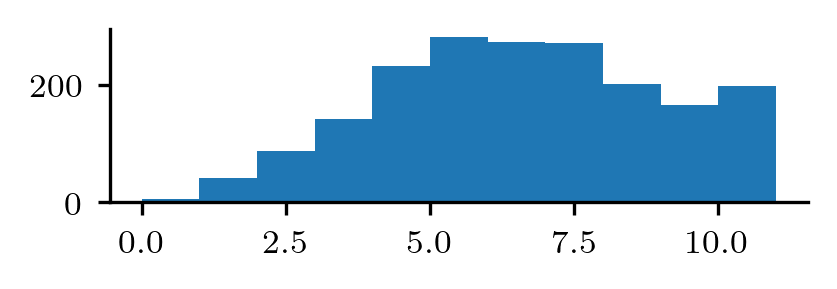

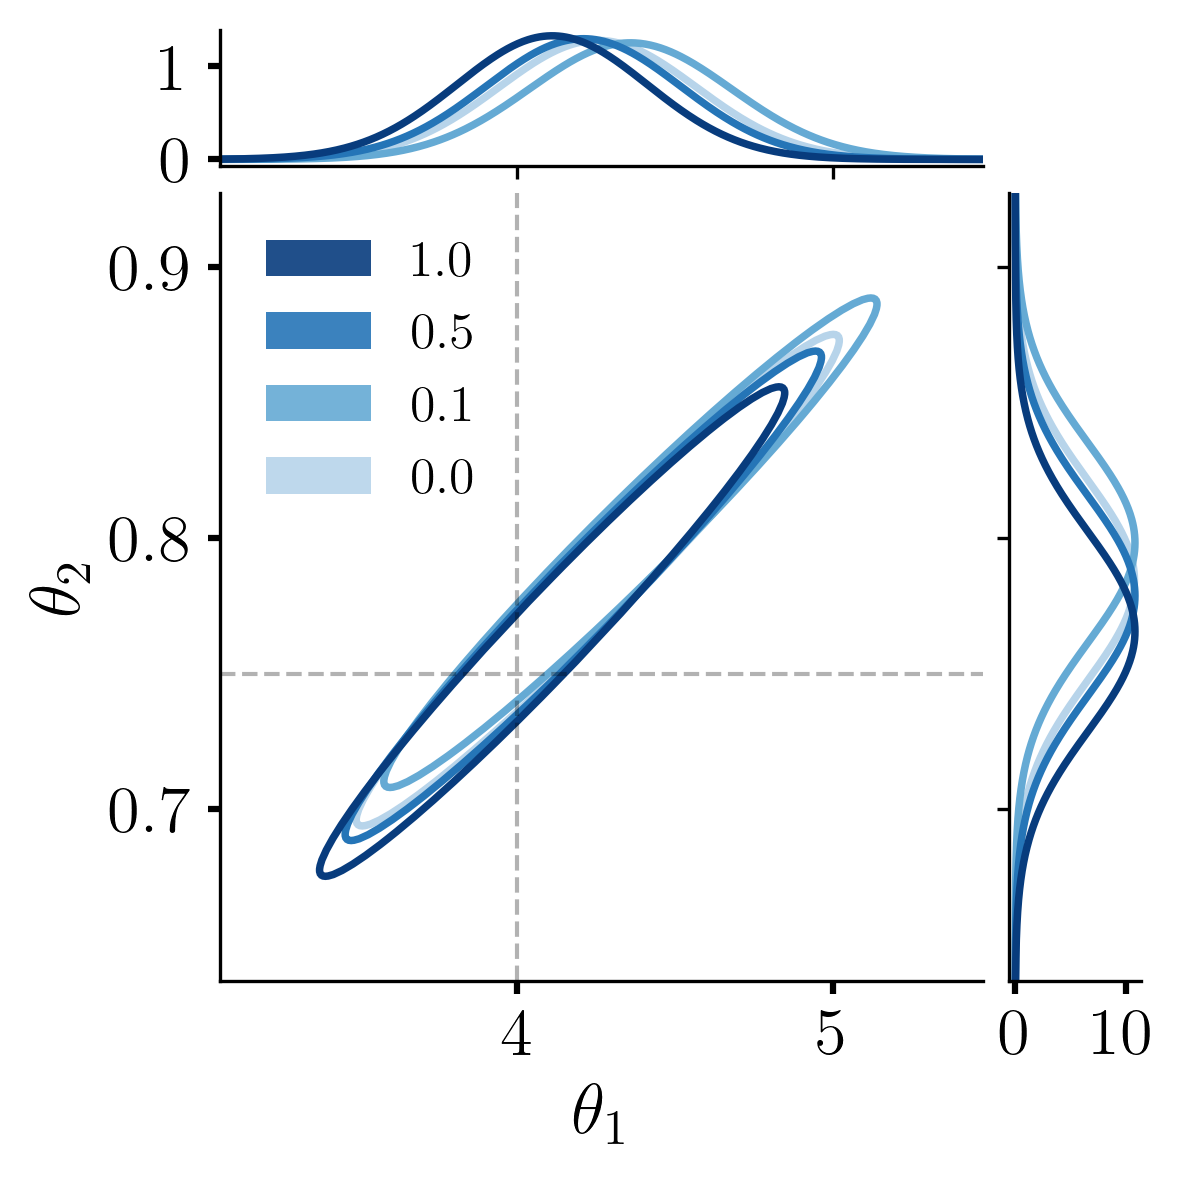

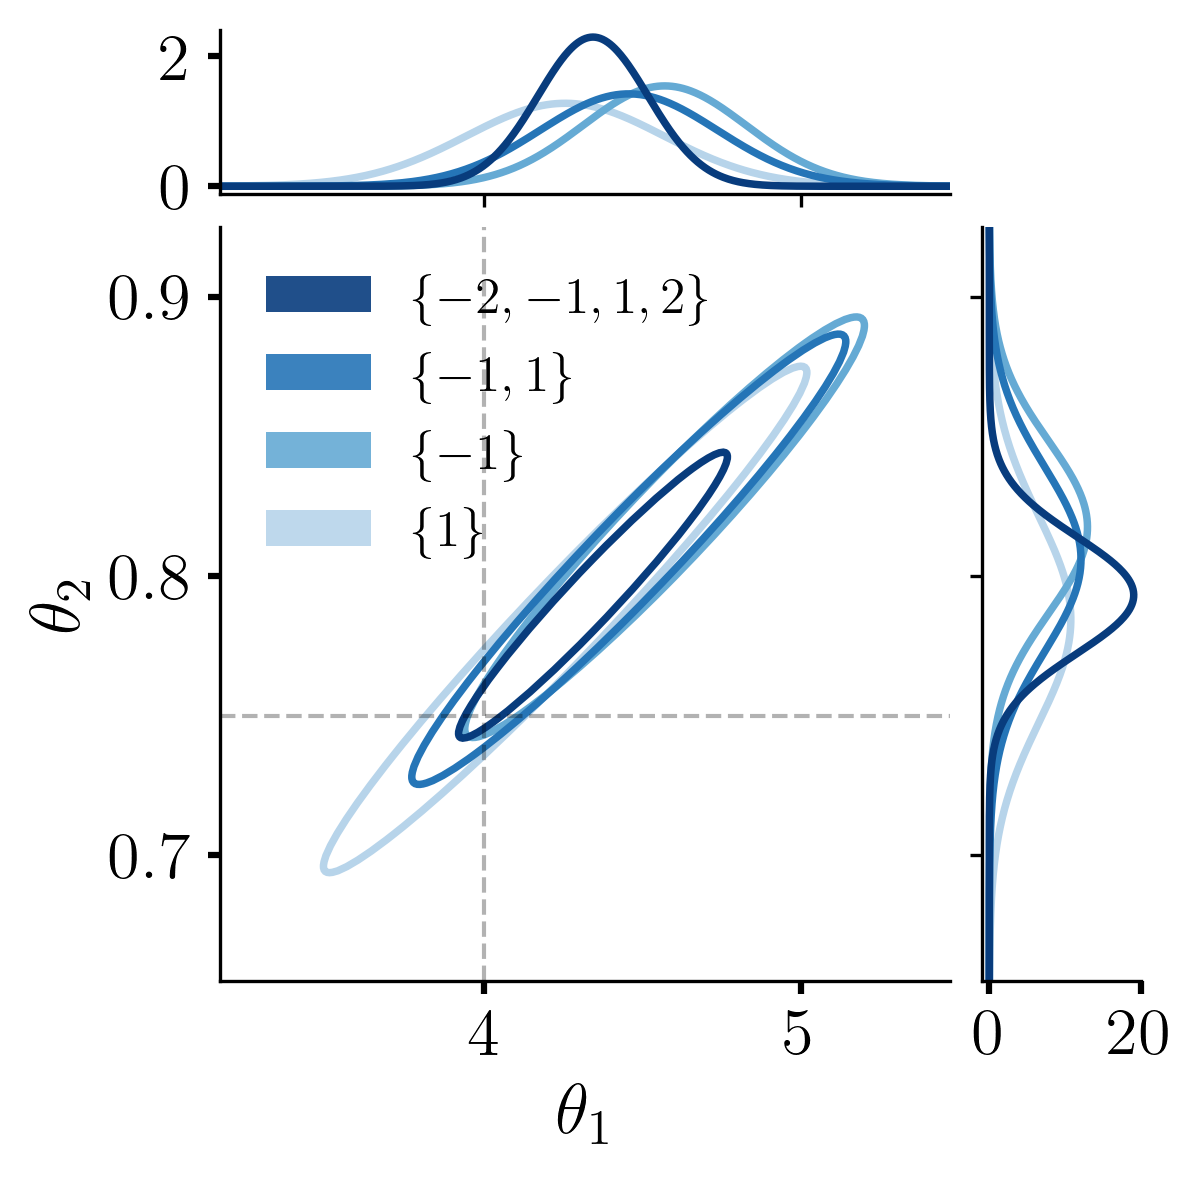

In [4]:
#Generic variables
n_samples = 2_000
circular= False
beta=1.
mu_prior=np.array([[3.],[3.]])
Sigma_prior=1. * np.eye(2)

save=False

theta1, theta2, i = 4.0, 0.75, 2
samples = np.load(f"./outputs/dataset{i}_theta1={theta1}_theta2={theta2}.npy").reshape(-1,1)

plt.figure(figsize=(3.,0.75))
plt.hist(samples, bins=np.arange(0,12))


# Test 1: vary alpha
j_vals=[1]

dist_list = []
alpha_list = [0.0, 0.1, 0.5, 1.]

for alpha in alpha_list:
    empirical = SmoothedEmpiricalDensity(alpha=alpha)
    empirical.fit(samples)
    cmp = CMP(d=1, empirical=empirical, j_vals=j_vals, circular=circular)
    rv = cmp.posterior(data=samples, beta=beta, mu_prior=mu_prior, Sigma_prior=Sigma_prior)
    mu, S = transform_logtheta_theta(rv.mean, rv.cov)
    print(mu)

    dist_list.append((mu, S))

fig = plot_gaussians_joint_marginals_filled_params(
    dist_list, alpha_list,
    probs=(0.95,),  # 50%, 80%, 95% mass
    height=3.7,
    ratio=5,
)
for mu, S in dist_list:
    print(mu[0]**(1/mu[1]))

if save: plt.savefig("results/alpha-vs-posterior.pdf", format='pdf', bbox_inches='tight')

# Test 2: vary M(x)
alpha=0.0

dist_list = []
#j_vals_list = [[1],[-1], [1,2], [-1,1], [-2,-1, 1, 2]]
j_vals_list = [[1],[-1], [-1,1], [-2,-1, 1, 2]]

for j_vals in j_vals_list:
    empirical = SmoothedEmpiricalDensity(alpha=alpha)
    empirical.fit(samples)
    cmp = CMP(d=1, empirical=empirical, j_vals=j_vals, circular=circular)
    rv = cmp.posterior(data=samples, beta=beta, mu_prior=mu_prior, Sigma_prior=Sigma_prior)
    mu, S = transform_logtheta_theta(rv.mean, rv.cov)

    dist_list.append((mu, S))

labels = [r"$\{1\}$", r"$\{-1\}$", r"$\{-1,1\}$", r"$\{-2, -1, 1, 2\}$"]

fig = plot_gaussians_joint_marginals_filled_params(
    dist_list, labels,
    probs=(0.95,),  # 50%, 80%, 95% mass
    height=3.7,
    ratio=4,
)

if save: plt.savefig("results/neighbours-vs-posterior.pdf", format='pdf', bbox_inches='tight')

In [5]:
#Calibrating beta for [-2, -1, 1, 2]

j_vals = [-2, -1, 1, 2]

empirical = SmoothedEmpiricalDensity(alpha=alpha)
empirical.fit(samples)
cmp = CMP(d=1, empirical=empirical, j_vals=j_vals, circular=circular)

beta_star_Mbig, cov, _ = cmp.fit_coverage(data=samples, prior_mean=mu_prior, prior_cov=Sigma_prior, B=50)
print(beta_star_Mbig, cov)

0.31805219934635137 0.9


In [ ]:
#Calibrating beta for [1]
j_vals = [1]

alpha=0.0
empirical = SmoothedEmpiricalDensity(alpha=alpha)
empirical.fit(samples)
cmp = CMP(d=1, empirical=empirical, j_vals=j_vals, circular=circular)

beta_star_Msmall, cov, _ = cmp.fit_coverage(data=samples, prior_mean=mu_prior, prior_cov=Sigma_prior, B=50)
print(beta_star_Msmall, cov)

1.1706301275236548 0.96


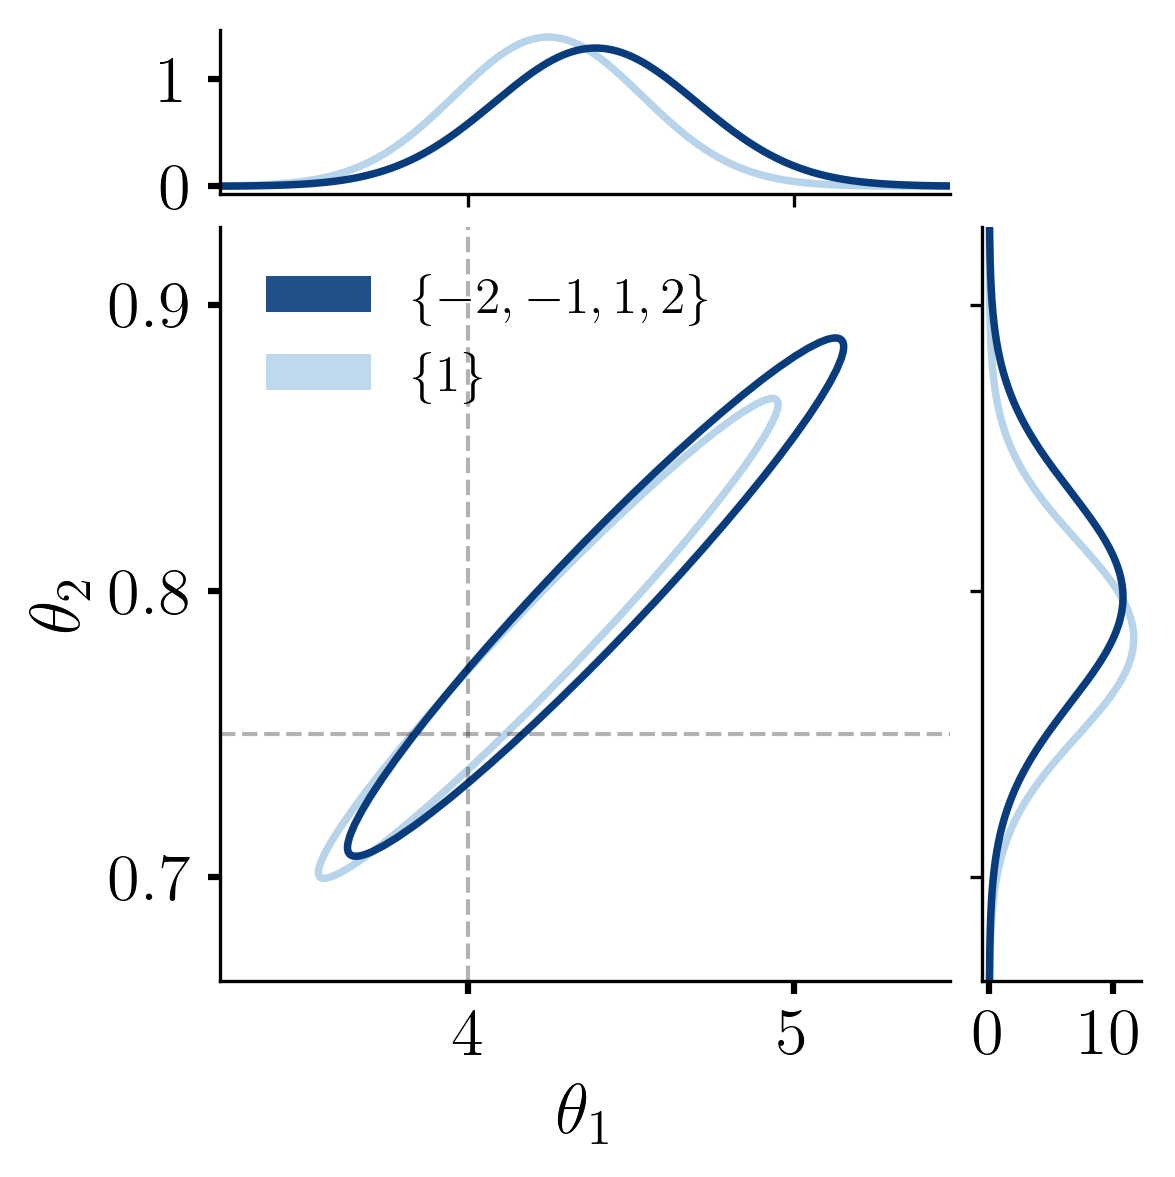

In [ ]:

dist_list = []
j_vals_list = [[1], [-2, -1, 1, 2]]
beta_list = [beta_star_Msmall, beta_star_Mbig]

save=False

for (j_vals, beta) in zip(j_vals_list, beta_list):
    empirical = SmoothedEmpiricalDensity(alpha=alpha)
    empirical.fit(samples)
    cmp = CMP(d=1, empirical=empirical, j_vals=j_vals, circular=circular)

    rv = cmp.posterior(data=samples, beta=beta, mu_prior=mu_prior, Sigma_prior=Sigma_prior)
    mu, S = transform_logtheta_theta(rv.mean, rv.cov)

    dist_list.append((mu, S))

labels = [r"$\{1\}$", r"$\{-2, -1, 1, 2\}$"]

fig = plot_gaussians_joint_marginals_filled_params(
    dist_list, labels,
    probs=(0.95,),  # 50%, 80%, 95% mass
    height=3.7,
    ratio=4,
)

if save: plt.savefig("results/neighbours-vs-posterior-calibrated.pdf", format='pdf', bbox_inches='tight')